In [48]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import random
import numpy as np
from scipy.optimize import curve_fit
import torch
from matplotlib import pyplot as plt
from syd import make_viewer, Viewer
from tqdm import tqdm


from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, format_spines, beeswarm, errorPlot, save_figure, edge2center, cross_validate_trials
from vrAnalysis.processors.placefields import get_placefield, get_frame_behavior
from dimensionality_manuscript.registry import PopulationRegistry
from dimensionality_manuscript.aiscientist.fit_model0 import (
    train_model,
    neuron_model_1d,
    gaussian_model_1d,
    parameter_estimator_torch,
    gaussian_parameter_estimator,
    PARAM_NAMES,
    N_PARAMS,
    GAUSSIAN_PARAM_NAMES,
)

plt.rcParams["font.size"] = 14

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Get sample data
spks_type = "oasis"
# session = random.choice(sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type)))
session = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))[40]
print(session)

B2Session(mouse_name='ATL022', date='2023-04-12', session_id='701', spks_type='oasis')


In [49]:
env_stats = session.env_stats
best_env = max(env_stats, key=env_stats.get)

# Get frame_behavior of session
frame_behavior = get_frame_behavior(session)

# Filter frame behavior
speed_threshold = 1.0
idx_fast = frame_behavior.speed > speed_threshold
idx_best_env = frame_behavior.environment == best_env
idx_valid_frames = frame_behavior.valid_frames()
idx_keep = idx_valid_frames & idx_fast & idx_best_env
frame_behavior = frame_behavior.filter(idx_keep)
idx_to_spks = np.where(idx_keep)[0]

# Get placefield
num_bins = 100
dist_edges = np.linspace(0, session.env_length[0], num_bins + 1)
spks = session.spks[:, session.idx_rois]
trial_folds = cross_validate_trials(session.trial_environment, [0.5, 0.5])
placefield_train = get_placefield(spks, frame_behavior, dist_edges, average=True, idx_to_spks=idx_to_spks, use_fast_sampling=True, session=session, trial_filter=trial_folds[0])
placefield_test = get_placefield(spks, frame_behavior, dist_edges, average=True, idx_to_spks=idx_to_spks, use_fast_sampling=True, session=session, trial_filter=trial_folds[1])

# Check stuff
placefield_train.shape, np.unique(placefield_train.environment)

((1, 100, 8833), array([3], dtype=int16))

In [52]:
dist_centers = edge2center(dist_edges)

# Prepare training and testing data
response_train = placefield_train[0].T
response_test = placefield_test[0].T

_idx_valid = np.logical_or(np.var(response_train, axis=1)>0, np.var(response_test, axis=1)>0)
response_train = response_train[_idx_valid]
response_test = response_test[_idx_valid]

_max = np.max(np.concatenate([response_train, response_test], axis=1), axis=1)
_max[_max<1e-6] = 1.0
_max = np.nan_to_num(_max)
response_train = response_train / _max[:, None]
response_test = response_test / _max[:, None]

params_nl, params_gauss, loss_nl, loss_gauss = train_model(dist_centers, response_train, steps=3000)

print("Nonlinear loss:", loss_nl)
print("Gaussian loss:", loss_gauss)
print("Nonlinear params (first cell):", dict(zip(PARAM_NAMES, params_nl[0].cpu().numpy())))
print("Gaussian params (first cell):", dict(zip(GAUSSIAN_PARAM_NAMES, params_gauss[0].cpu().numpy())))

100%|██████████| 3000/3000 [00:10<00:00, 296.27it/s]

Nonlinear loss: 0.017485229298472404
Gaussian loss: 0.019060751423239708
Nonlinear params (first cell): {'x_pref': 96.63504, 'baseline': 0.00065821473, 'amplitude': 0.6835884, 'width_left': 10.097185, 'width_right': 9.494127, 'exponent': 3.373356}
Gaussian params (first cell): {'x_pref': 96.857574, 'baseline': -0.009441945, 'amplitude': 0.700602, 'width': 9.561028}


0.024951208131485592 0.025352487172397603
0.9173420769316388 0.9841720049720052


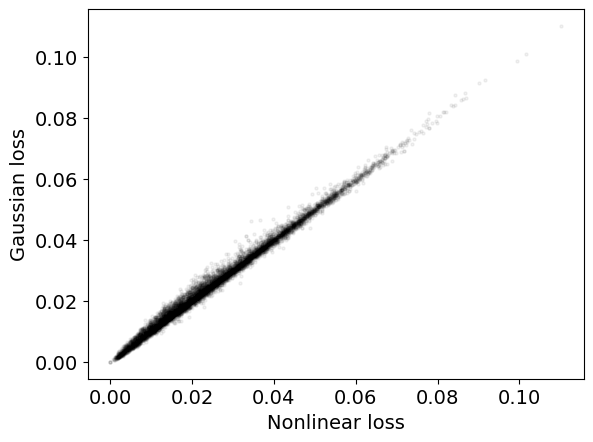

In [58]:
nl_pred = neuron_model_1d(torch.tensor(dist_centers).to(device), params_nl).cpu()
gauss_pred = gaussian_model_1d(torch.tensor(dist_centers).to(device), params_gauss).cpu()

nl_loss = torch.mean((nl_pred - response_test) ** 2, dim=1)
gauss_loss = torch.mean((gauss_pred - response_test) ** 2, dim=1)

print(nl_loss.mean().item(), gauss_loss.mean().item())

print(loss_nl / loss_gauss, nl_loss.mean().item() / gauss_loss.mean().item())
plt.close('all')
plt.scatter(nl_loss, gauss_loss, color="k", alpha=0.05, s=5)
plt.xlabel('Nonlinear loss')
plt.ylabel('Gaussian loss')
plt.show()

In [54]:
def plot(state):
    neuron_index = state['neuron_index']
    neuron_response = response_test[neuron_index]
    dcenter_torch = torch.tensor(dist_centers).to(device)   
    neuron_pred = neuron_model_1d(dcenter_torch, params_nl[[neuron_index]]).cpu()
    gauss_pred = gaussian_model_1d(dcenter_torch, params_gauss[[neuron_index]]).cpu()

    pred_loss = 1e3 * torch.mean((neuron_pred - neuron_response) ** 2)
    gauss_loss = 1e3 * torch.mean((gauss_pred - neuron_response) ** 2)
    loss_str = f"Pred loss (*1e3): {pred_loss:.1f}, Gauss loss: {gauss_loss:.1f}"

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(dist_centers, neuron_response, 'k.')
    ax.plot(dist_centers, neuron_pred[0], 'r-')
    ax.plot(dist_centers, gauss_pred[0], 'g-')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Response')
    ax.set_title(loss_str)
    ax.legend(['Response', 'NL Pred', 'Gauss Pred'])
    return fig

viewer = make_viewer(plot)
viewer.add_integer("neuron_index", min=0, max=len(response_test)-1)
viewer.show()